# Generation for NLP Baseline Code

## Install Packages

## Import Necessary Libraries

In [2]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', None)

In [3]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## EDA

### Load Data

In [ ]:
 # Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('/data/ephemeral/home/bsw/data/train.csv') 
dataset

In [ ]:
paragraph = dataset.loc[0]['paragraph']
problem = dataset.loc[0]['problems']

print(paragraph)
print(problem)

In [7]:
# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [ ]:
df.head()

### Print missing values

In [9]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
dtype: int64


### Basic information about the dataset

In [10]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


### EDA on 'question' and 'choices'

In [11]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)

In [ ]:
df['full_question']

### Question Length Distribution

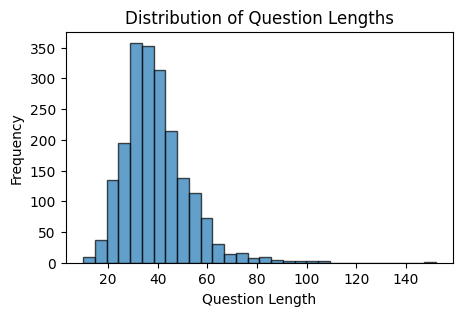

In [13]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering using TF-IDF

- TF-IDF 참고 링크: https://ko.wikipedia.org/wiki/Tf-idf

### Initialize TF-IDF Vectorizer

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

### Fit and transform the text data

In [15]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_question'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### Display the TF-IDF features

In [16]:
print("\nTF-IDF Features:")
display(tfidf_df.head(20))


TF-IDF Features:


11월  12월  1450  1450년에서  1750  1750년  17세기  1800년대  1860년  1960년대  1999년  \
0   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
1   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
2   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
3   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
4   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
5   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
6   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
7   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
8   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
9   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
10  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
11  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
12  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
13  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
14  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
15  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
16  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
17  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
18  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
19  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   

    19세기  1분기   1월   1위  1위를   1의  2008년  2010년  2013년  2014  2014년  2014년도  \
0    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
5    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
6    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
7    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
8    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
9    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
10   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
11   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
12   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
13   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
14   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
15   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
16   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
17   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
18   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
19   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   

    2015학년도  2019  2019년  2020  2020년  20세기  2분기  2에서  3분기   5년   5월  600  \
0       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7       0.0   0.0    0.0   0.0    0.0   0.0  0.

## Model Training

### Baseline Model

- https://huggingface.co/beomi/gemma-ko-2b

In [ ]:
# 본인의 Huggingface auth token 입력
## Jupyter lab에서 로그인 하는 textbox가 나오지 않을 경우, terminal에서 로그인 하실 수 있습니다.
!huggingface-cli login
# from huggingface_hub import notebook_login
# notebook_login()

모델과 토크나이저를 불러옵니다.

In [18]:
model = AutoModelForCausalLM.from_pretrained(
    "LGAI-EXAONE/EXAONE-3.0-7.8B-Instruct",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "LGAI-EXAONE/EXAONE-3.0-7.8B-Instruct",
    trust_remote_code=True,
)

model.gradient_checkpointing_enable()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
tokenizer.chat_template

"{% for message in messages %}{% if loop.first and message['role'] != 'system' %}{{ '[|system|][|endofturn|]\n' }}{% endif %}{{ '[|' + message['role'] + '|]' + message['content'] }}{% if message['role'] == 'user' %}{{ '\n' }}{% else %}{{ '[|endofturn|]\n' }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '[|assistant|]' }}{% endif %}"

In [20]:
test_messages = [{'role': 'system', 'content': '지문을 읽고 질문의 답을 구하세요.'},
  {'role': 'user',
   'content': '지문:\n상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.\n\n질문:\n상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?\n\n선택지:\n1 - ㄱ, ㄴ\n2 - ㄱ, ㄷ\n3 - ㄴ, ㄹ\n4 - ㄷ, ㄹ\n\n1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n정답:'},
  {'role': 'assistant', 'content': '2'}]
 
tokenizer.apply_chat_template(
                test_messages,
                tokenize=False,
            )

'[|system|]지문을 읽고 질문의 답을 구하세요.[|endofturn|]\n[|user|]지문:\n상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.\n\n질문:\n상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?\n\n선택지:\n1 - ㄱ, ㄴ\n2 - ㄱ, ㄷ\n3 - ㄴ, ㄹ\n4 - ㄷ, ㄹ\n\n1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n정답:\n[|assistant|]2[|endofturn|]\n'

### Prepare LoRA

In [21]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=['q_proj', 'k_proj'],
    bias="none",
    task_type="CAUSAL_LM",
)

### Data Processing

In [22]:
dataset = Dataset.from_pandas(df)

In [23]:
PROMPT_NO_QUESTION_PLUS = """지문:
{paragraph}

배경 지식:
{document}

질문:
{question}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

PROMPT_QUESTION_PLUS = """지문:
{paragraph}

배경 지식:
{document}

질문:
{question}

<보기>:
{question_plus}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

In [24]:
dataset

Dataset({
    features: ['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus', 'full_question', 'question_length'],
    num_rows: 2031
})

### Dense Retriever

In [25]:
from dense_retriever import DenseRetriever
# Dense Retriever 로드
print("Loading Dense retriever...")
dense_retriever = DenseRetriever.load("wikipedia_index_dense", load_corpus=True)

Loading Dense retriever...


### Sparse Retriever

In [26]:
from konlpy.tag import Mecab
import bm25s

# tqdm과 pandas 결합
tqdm.pandas()

# Mecab 객체 생성
mecab = Mecab()

In [27]:
# 저장된 BM25 인덱스 로드
print("Loading BM25 index and document data...")
retriever = bm25s.BM25.load("wikipedia_index_bm25", load_corpus=True)
print("BM25 index and document data successfully loaded.")

Loading BM25 index and document data...
BM25 index and document data successfully loaded.


### Hybrid Retriever

In [27]:
from sentence_transformers import SentenceTransformer, util

def get_combined_docs_with_similarity(item, dense_retriever, bm25_retriever, mecab, k_bm25=20):
    """
    question과 각 choice별로 가장 유사도가 높은 문서들을 선택
    """
    model = SentenceTransformer('jhgan/ko-sbert-nli')
    
    # BM25 검색
    query_tokens = bm25s.tokenize(' '.join(mecab.morphs(item['paragraph'])))
    bm25_results, bm25_scores = bm25_retriever.retrieve(query_tokens, k=k_bm25)
    bm25_docs = [result['text'] for result in bm25_results[0]]
    
    # 문서들을 임베딩
    doc_embeddings = model.encode(bm25_docs, convert_to_tensor=True)
    
    # Question 유사도 계산
    question_embedding = model.encode(item['question'], convert_to_tensor=True)
    question_similarities = util.pytorch_cos_sim(question_embedding, doc_embeddings)[0]
    
    # Choices 각각의 유사도 계산
    choices_embeddings = model.encode(item['choices'], convert_to_tensor=True)
    choices_similarities = util.pytorch_cos_sim(choices_embeddings, doc_embeddings)
    
    # 선택된 문서들을 저장할 set
    selected_docs = set()
    
    # Question에 대해 가장 유사도가 높은 문서 선택
    question_top_idx = torch.argmax(question_similarities).item()
    selected_docs.add(bm25_docs[question_top_idx])
    
    # print("\n=== Question 관련 최적 문서 ===")
    # print(f"질문: {item['question']}")
    # print(f"유사도: {float(question_similarities[question_top_idx]):.4f}")
    # print(f"선택된 문서: {bm25_docs[question_top_idx][:200]}...")
    
    # 각 Choice별로 가장 유사도가 높은 문서 선택
    # print("\n=== Choices 관련 최적 문서 ===")
    for idx, choice in enumerate(item['choices']):
        choice_similarities = choices_similarities[idx]
        top_idx = torch.argmax(choice_similarities).item()
        selected_docs.add(bm25_docs[top_idx])
        
        # print(f"\n선택지 {idx+1}: {choice}")
        # print(f"유사도: {float(choice_similarities[top_idx]):.4f}")
        # print(f"선택된 문서: {bm25_docs[top_idx][:200]}...")
    
    # 모든 선택된 문서 결합
    final_docs = list(selected_docs)
    
    # print(f"\n총 선택된 문서 수: {len(final_docs)}")
    
    # BM25 점수도 함께 표시
    # print("\n=== 선택된 문서들의 BM25 점수 ===")
    for doc in final_docs:
        doc_idx = bm25_docs.index(doc)
        # print(f"BM25 점수: {float(bm25_scores[0][doc_idx]):.4f}")
        # print(f"문서 내용: {doc[:200]}...\n")
    
    return "\n".join(final_docs)

#### RAG 배경지식 추가

In [ ]:
import concurrent.futures

def process_single_item(item):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(item["choices"])])
    
    # 문서 검색 및 선택
    docs = get_combined_docs_with_similarity(
        item, 
        dense_retriever=dense_retriever, 
        bm25_retriever=retriever,
        mecab=mecab,
        k_bm25=20
    )
    
    if item["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=item["paragraph"],
            document=docs,
            question=item["question"],
            question_plus=item["question_plus"],
            choices=choices_string,
        )
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=item["paragraph"],
            document=docs,
            question=item["question"],
            choices=choices_string,
        )
        
    return {
        "id": item["id"],
        "messages": [
            {"role": "system", "content": """당신은 수능 문제 출제 의원입니다. 
1. 지문을 꼼꼼히 읽고 핵심 내용을 파악하세요
2. 질문의 의도를 정확히 이해하세요
3. 주어진 배경 지식을 보조 자료로 활용하세요
4. 논리적인 근거를 바탕으로 가장 적절한 답을 구하세요"""},
            {"role": "user", "content": user_message},
            {"role": "assistant", "content": f"{item['answer']}"}
        ],
        "label": item["answer"],
    }

# 병렬 처리 실행
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    processed_dataset = list(tqdm(
        executor.map(process_single_item, [dataset[i] for i in range(len(dataset))]),
        total=len(dataset),
        desc="Processing documents"
    ))

In [76]:
processed_dataset[0]

{'id': 'generation-for-nlp-425',
 'messages': [{'role': 'system',
   'content': '당신은 수능 문제 출제 의원입니다. \n1. 지문을 꼼꼼히 읽고 핵심 내용을 파악하세요\n2. 질문의 의도를 정확히 이해하세요\n3. 주어진 배경 지식을 보조 자료로 활용하세요\n4. 논리적인 근거를 바탕으로 가장 적절한 답을 구하세요'},
  {'role': 'user',
   'content': '지문:\n상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.\n\n배경 지식:\n허목 은 사종 지설 중 체이 부정 의 서자 庶子 를 첩 에게서 태어난 첩자 妾子 에게 만 해당 되 는 것 으로 해석 했 다 . 그 는 장자 이외 에 는 서자 로 본다는 송시열 , 송준길 의 주장 에 반박 , 체이 부정 의 서자 를 첩자 로 간주 하 는 이른바 서자 첩 자설 을 주장 하 여 효종 은 인 열 왕후 라는 정실 소생 이 니 이 에 해당 되 지 않 는다고 주장 하 였 다 . 그 는 정체 는 할아버지 아버지 아들 로 이어지 는 법통 으로 , 정체 는 장남 만 이 아니 라 적자 에서 적자 로 이어진 경우 도 정체 로 보 고 삼 년 복 을 주장 했 다 . 그리고 차자 로서 대통 을 계승 한 것 은 아버지 의 뜻 에 따라 왕통 을 계승 했으니 역시 장남 이 고 삼 년 복 

In [77]:
processed_dataset = Dataset.from_pandas(pd.DataFrame(processed_dataset))
processed_dataset

Dataset({
    features: ['id', 'messages', 'label'],
    num_rows: 2031
})

In [78]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_dataset.map(
    tokenize,
    remove_columns=list(processed_dataset.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=True,
    desc="Tokenizing",
)

Tokenizing (num_proc=4):   0%|          | 0/2031 [00:00<?, ? examples/s]

In [ ]:
from sklearn.model_selection import KFold, train_test_split


dataset_indices = list(range(len(tokenized_dataset)))

# 데이터 분할
train_index, test_index = train_test_split(
    dataset_indices, test_size=0.2, shuffle=True, random_state=42
)

train_dataset = tokenized_dataset.select(train_index)
eval_dataset = tokenized_dataset.select(test_index)

print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=False))
print(tokenizer.decode(train_dataset[1]["input_ids"], skip_special_tokens=False))

In [80]:
train_dataset_token_lengths = [len(train_dataset[i]["input_ids"]) for i in range(len(train_dataset))]
print(f"max token length: {max(train_dataset_token_lengths)}")
print(f"min token length: {min(train_dataset_token_lengths)}")
print(f"avg token length: {np.mean(train_dataset_token_lengths)}")

max token length: 2660
min token length: 273
avg token length: 1125.7426108374384


In [81]:
print(len(train_dataset))
print(len(eval_dataset))

1624
407


In [28]:
print(tokenizer.chat_template)

{% for message in messages %}{% if loop.first and message['role'] != 'system' %}{{ '[|system|][|endofturn|]
' }}{% endif %}{{ '[|' + message['role'] + '|]' + message['content'] }}{% if message['role'] == 'user' %}{{ '
' }}{% else %}{{ '[|endofturn|]
' }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '[|assistant|]' }}{% endif %}


Completion 부분만 학습하기 위한 data collator 설정

- 텍스트 중 response_template 까지는 ignore_index 로 loss 계산에서 제외
- 텍스트 중 response_template 이후는 학습에 포함 (정답 + eos 토큰)

In [28]:
response_template = "[|assistant|]"
data_collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template,
    tokenizer=tokenizer,
)

### Metric 설정

In [29]:
# 모델의 logits 를 조정하여 정답 토큰 부분만 출력하도록 설정
def preprocess_logits_for_metrics(logits, labels):
    logits = logits if not isinstance(logits, tuple) else logits[0]
    logit_idx = [tokenizer.vocab["1"], tokenizer.vocab["2"], tokenizer.vocab["3"], tokenizer.vocab["4"], tokenizer.vocab["5"]]
    logits = logits[:, -2, logit_idx] # -2: answer token, -1: eos token
    return logits

# metric 로드
acc_metric = evaluate.load("accuracy")

# 정답 토큰 매핑
int_output_map = {"1": 0, "2": 1, "3": 2, "4": 3, "5": 4}

# metric 계산 함수
def compute_metrics(evaluation_result):
    logits, labels = evaluation_result

    # 토큰화된 레이블 디코딩
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    labels = list(map(lambda x: x.split("[|endofturn|]")[0].strip(), labels))
    labels = list(map(lambda x: int_output_map[x], labels))

    # 소프트맥스 함수를 사용하여 로그트 변환
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)
    predictions = np.argmax(probs, axis=-1)

    # 정확도 계산
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return acc

### Train

In [30]:
# pad token 설정
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.special_tokens_map

{'bos_token': '[BOS]',
 'eos_token': '[|endofturn|]',
 'unk_token': '[UNK]',
 'pad_token': '[|endofturn|]'}

In [ ]:
%%time
from sklearn.model_selection import KFold, train_test_split

tokenizer.padding_side = 'right'

dataset_indices = list(range(len(tokenized_dataset)))

# 데이터 분할
train_index, test_index = train_test_split(
    dataset_indices, test_size=0.2, shuffle=True, random_state=42
)

train_dataset = tokenized_dataset.select(train_index)
eval_dataset = tokenized_dataset.select(test_index)    


current_output_dir = "outputs_exaone_hybrid"
    
sft_config = SFTConfig(
    do_train=True,
    do_eval=True,
    lr_scheduler_type="cosine_with_restarts",
    max_seq_length=4096,
    output_dir=current_output_dir,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_total_limit=2,
    save_only_model=True,
    report_to="none",
    fp16=True,
    fp16_full_eval=True,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    peft_config=peft_config,
    args=sft_config,
)



In [89]:
# 모델 학습
trainer.train()

# 모델 평가
metrics = trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Accuracy
500,0.296900,0.289500,0.484029
1000,0.203500,0.303054,0.484029


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


## Inference

In [49]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
# TODO 학습된 Checkpoint 경로 입력
checkpoint_path = "./outputs_exaone_hybrid/checkpoint-1218"

model = AutoPeftModelForCausalLM.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)
model = model.to('cuda')  
tokenizer = AutoTokenizer.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [33]:
# Load the test dataset
# TODO Test Data 경로 입력
test_df = pd.read_csv('/data/ephemeral/home/bsw/data/test.csv')

# Flatten the JSON dataset
records = []
for _, row in test_df.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
test_df = pd.DataFrame(records)

### Hybrid Retriever

In [34]:
from sentence_transformers import SentenceTransformer, util

def get_combined_docs_with_similarity(item, dense_retriever, bm25_retriever, mecab, k_bm25=20):
    """
    question과 각 choice별로 가장 유사도가 높은 문서들을 선택 (출력 없이)
    """
    model = SentenceTransformer('jhgan/ko-sbert-nli')    
    
    # BM25 검색
    query_tokens = bm25s.tokenize(' '.join(mecab.morphs(item['paragraph'])))
    bm25_results, bm25_scores = bm25_retriever.retrieve(query_tokens, k=k_bm25, show_progress=False)
    bm25_docs = [result['text'] for result in bm25_results[0]]
    
    # 문서들을 임베딩
    doc_embeddings = model.encode(bm25_docs, convert_to_tensor=True, show_progress_bar=False)
    
    # Question 유사도 계산
    question_embedding = model.encode(item['question'], convert_to_tensor=True)
    question_similarities = util.pytorch_cos_sim(question_embedding, doc_embeddings)[0]
    
    # Choices 각각의 유사도 계산
    choices_embeddings = model.encode(item['choices'], convert_to_tensor=True)
    choices_similarities = util.pytorch_cos_sim(choices_embeddings, doc_embeddings)
    
    # 선택된 문서들을 저장할 set
    selected_docs = set()
    
    # Question에 대해 가장 유사도가 높은 문서 선택
    question_top_idx = torch.argmax(question_similarities).item()
    selected_docs.add(bm25_docs[question_top_idx])
    
    # 각 Choice별로 가장 유사도가 높은 문서 선택
    for idx, choice in enumerate(item['choices']):
        choice_similarities = choices_similarities[idx]
        top_idx = torch.argmax(choice_similarities).item()
        selected_docs.add(bm25_docs[top_idx])
    
    # 선택된 문서들을 결합하여 반환
    return "\n".join(selected_docs)

#### RAG 배경지식 추가

In [ ]:
import concurrent.futures

def process_test_item(row):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(row["choices"])])
    len_choices = len(row["choices"])
    
    # 문서 검색 및 선택
    docs = get_combined_docs_with_similarity(
        row, 
        dense_retriever=dense_retriever, 
        bm25_retriever=retriever,
        mecab=mecab,
        k_bm25=20
    )
    
    # <보기>가 있을 때
    if row["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            document=docs,
            question=row["question"],
            question_plus=row["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            document=docs,
            question=row["question"],
            choices=choices_string,
        )

    return {
        "id": row["id"],
        "messages": [
            {"role": "system", "content": """당신은 수능 문제 출제 의원입니다. 
1. 지문을 꼼꼼히 읽고 핵심 내용을 파악하세요
2. 질문의 의도를 정확히 이해하세요
3. 주어진 배경 지식을 보조 자료로 활용하세요
4. 논리적인 근거를 바탕으로 가장 적절한 답을 구하세요"""},
            {"role": "user", "content": user_message},
        ],
        "label": row["answer"],
        "len_choices": len_choices,
    }

# 병렬 처리 실행
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    test_dataset = list(tqdm(
        executor.map(process_test_item, [test_df.iloc[i] for i in range(len(test_df))]),
        total=len(test_df),
        desc="Processing test documents"
    ))

In [ ]:
test_dataset

In [41]:
import gc

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

In [42]:
%%time

infer_results = []

pred_choices_map = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"}

model.eval()
with torch.inference_mode():
    for data in tqdm(test_dataset):
        _id = data["id"]
        messages = data["messages"]
        len_choices = data["len_choices"]

        outputs = model(
            tokenizer.apply_chat_template(
                messages,
                tokenize=True,
                add_generation_prompt=True,
                return_tensors="pt",
            ).to("cuda")
        )

        logits = outputs.logits[:, -1].flatten().cpu()

        target_logit_list = [logits[tokenizer.vocab[str(i + 1)]] for i in range(len_choices)]

        probs = (
            torch.nn.functional.softmax(
                torch.tensor(target_logit_list, dtype=torch.float32)
            )
            .detach()
            .cpu()
            .numpy()
        )

        predict_value = pred_choices_map[np.argmax(probs, axis=-1)]
        row = {"id": _id, "answer": predict_value}
                
        target_logit_list = [logit.item() for logit in target_logit_list]
        if len_choices < len(pred_choices_map):
            target_logit_list += [None] * (len(pred_choices_map) - len_choices)
        for i, logit in enumerate(target_logit_list):
            row[f"logit_{pred_choices_map[i]}"] = logit

        infer_results.append(row)

100%|██████████| 869/869 [35:46<00:00,  2.47s/it] 

CPU times: user 24min 46s, sys: 11min, total: 35min 47s
Wall time: 35min 46s


In [43]:
pd.DataFrame(infer_results).to_csv("output_exaone_hybrid_4096.csv", index=False)

In [44]:
pd.DataFrame(infer_results)

,id,answer,logit_1,logit_2,logit_3,logit_4,logit_5
0,generation-for-nlp-0,2,27.000,28.125,27.625,26.875,27.125
1,generation-for-nlp-1,1,28.250,27.500,27.625,27.500,26.750
2,generation-for-nlp-2,4,29.875,29.625,26.500,34.750,28.000
3,generation-for-nlp-3,1,31.875,30.750,30.375,29.500,30.375
4,generation-for-nlp-4,3,28.875,29.250,30.250,29.750,28.375
...,...,...,...,...,...,...,...
864,generation-for-nlp-1609,1,33.250,25.625,24.375,24.125,21.375
865,generation-for-nlp-1512,1,34.250,25.250,22.125,22.875,19.750
866,generation-for-nlp-1382,3,25.125,25.000,33.250,24.000,20.500
867,generation-for-nlp-702,4,27.625,26.750,30.625,33.500,NaN



답안 분포:
answer
1    288
2    187
4    180
3    175
5     39
Name: count, dtype: int64

비율 분포:
answer
1    33.141542
2    21.518987
4    20.713464
3    20.138090
5     4.487917
Name: count, dtype: float64 %


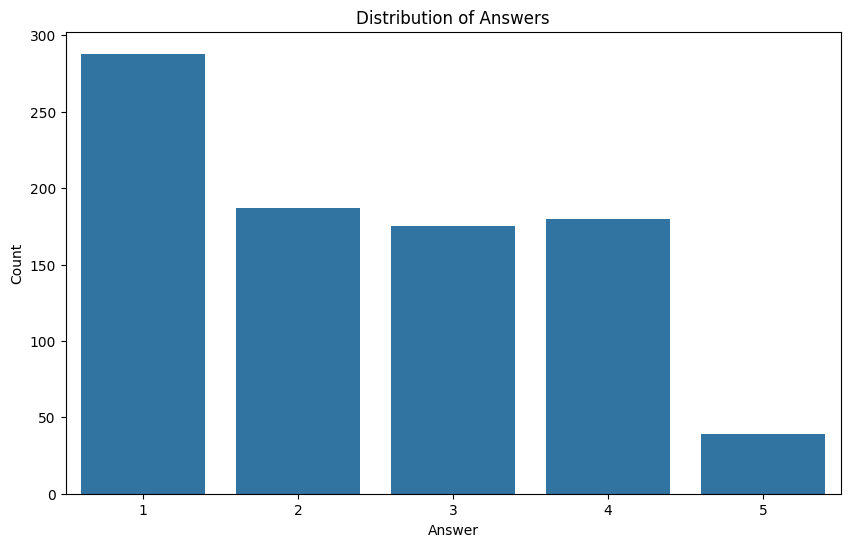

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일 읽기
df = pd.read_csv("output_exaone_hybrid_4096.csv")

# answer 컬럼의 값 개수 확인
value_counts = df['answer'].value_counts()
print("\n답안 분포:")
print(value_counts)
print("\n비율 분포:")
print(value_counts / len(df) * 100, "%")

# 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='answer')
plt.title('Distribution of Answers')
plt.xlabel('Answer')
plt.ylabel('Count')
plt.show()